In [1]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Ch.3 ベイズ推論の基礎

## 3.1 確率推論

### 3.1.4 変数変換
1次元ガウス分布の変数変換の例（図3.1）

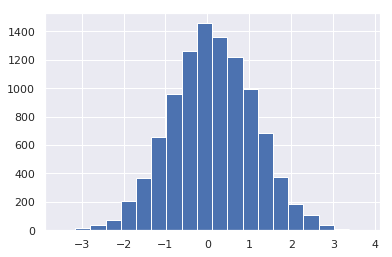

In [2]:
mu = 0.1
var = 1.0
x = stats.norm(loc=mu, scale=var).rvs(size=10000)

ret = plt.hist(x, bins=20)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in arctanh
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


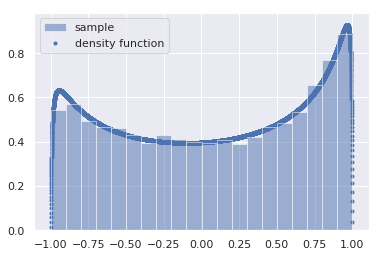

In [3]:
# xを単純に変換する
y = np.tanh(x)

# 変数変換した確率密度関数
ys = np.linspace(-1.0, 1.0, 10000)
py = stats.norm(loc=mu, scale=var).pdf(x=np.arctanh(ys))/(1-ys*ys)

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
ax.hist(y, bins=20, density=True, alpha=0.5, label='sample')
ax.scatter(ys, py, marker='.', label='density function')
ax.legend()


## 3.2 指数型分布族

### 3.2.1 確率分布の例
#### ガンマ分布

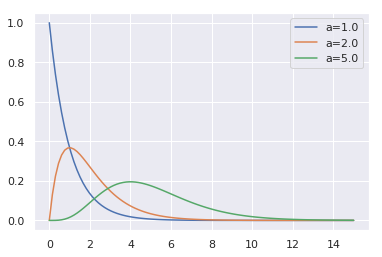

In [4]:
xs = np.linspace(0.0, 15.0, 100)
aa = [1.0, 2.0, 5.0]
loc = 0
scale = 1

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
for a in aa:
    pdf = stats.gamma.pdf(x=xs, a=a, loc=loc, scale=scale)
    ax.plot(xs, pdf, '-', label='a={}'.format(a))
ax.legend()

## 3.3 ベイズ線形回帰
### モデル

$$
p(y_n | x_n, w) = N(y_n | w^T\phi(x_n), \sigma_y^2)
$$

$$
p(w) = N(w|0, \sigma_w^2I)
$$


モデルからいくつか関数をサンプルしてみる（事前分布から）

In [5]:
def polynomial(x, degree):
    """多項式
    """
    return [np.power(x, d) for d in np.arange(0, degree+1)]

### 事前分布から関数（w）をサンプル

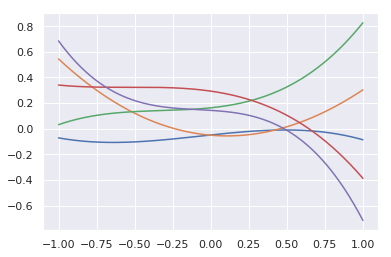

In [6]:
n_degree = 3 # モデルの次数
var_w = 0.1  # wの事前分布の分散
size = 5 # 事前分布からサンプルする個数

# 事前分布からwをサンプリング
m = np.zeros(n_degree+1)
v = var_w * np.identity(n_degree+1)
ws = stats.multivariate_normal.rvs(mean=m, cov=v, size=size)

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(-1.0, 1.0, 1000)
for w in ws:
    sample_prior = list(map(lambda x:np.dot(w, polynomial(x=x, degree=n_degree)), xs))
    ax.plot(xs, sample_prior, '-')

### 真の関数からデータをサンプルしてみる
- 適当に真の関数を設定
  - 今回は正弦波を設定
- サンプルデータを抽出

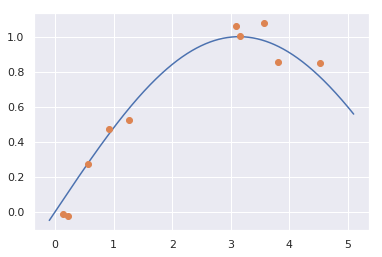

In [7]:
def true_func(x, params=None):
    y = params['gain'] * np.sin(x * params['omega'])
    return y
def observation_model(x, var=1.0, true_model_params=None):
    ty = true_func(x, params=true_model_params)
    y = stats.norm.rvs(loc=ty, scale=np.sqrt(var))
    return y

xmin,xmax = 0, 5
sample_x = xmin + (xmax-xmin)*np.random.rand(10) # 純粋にランダムにサンプル
#sample_x = np.concatenate([(xmin+(4-xmin)*np.random.rand(1)), (4+(xmax-4)*np.random.rand(2))]) # 区間を分けてサンプル


#tfunc_params = {'gain':1., 'omega':1.5}
tfunc_params = {'gain':1., 'omega':0.5}
var_y = 0.01
sample_y = list(map(lambda x:observation_model(x, var=var_y, true_model_params=tfunc_params), sample_x))

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=tfunc_params), xs))
ax.plot(xs, tys, '-')
ax.plot(sample_x, sample_y, 'o')

### ベイズ線形回帰の学習（重みwの事後分布）
上記のサンプルデータを学習データとして、ベイズ線形回帰を学習（重みwの事後分布を算出）
- 線形回帰なので事後分布は解析解が得られる

$$
\begin{align}
p(\mathbf{w} | \mathbf{Y}, \mathbf{X}) &= \mathcal{N}(\mathbf{w} | \hat{\boldsymbol{\mu}}, \hat{\mathbf{\Sigma}}) \\
\hat{\mathbf{\Sigma}}^{-1} &= \sigma_{y}^{-2} \sum_{n=1}^{N} \phi\left(\mathbf{x}_{n}\right) \phi\left(\mathbf{x}_{n}\right)^{\top}+\sigma_{w}^{-2} \mathbf{I} \\ 
\hat{\boldsymbol{\mu}} &= \hat{\mathbf{\Sigma}} \sigma_{y}^{-2} \sum_{n=1}^{N} y_{n} \phi\left(\mathbf{x}_{n}\right)
\end{align}
$$


In [8]:
# 事後分布の分散共分散行列
def outer_feature(x, degree=n_degree):
    feature = polynomial(x=x, degree=degree)
    return np.outer(feature, feature)
sum_feature = sum(map(outer_feature, sample_x))
S_hat_inv = (1.0/var_y) * sum_feature + (1.0/var_w) * np.identity((n_degree+1))
S_hat = np.linalg.inv(S_hat_inv)

# 事後分布の平均ベクトル
sum_yf = sum(map(lambda xy:np.array(polynomial(x=xy[0], degree=n_degree)) * xy[1], zip(sample_x, sample_y)))
tmp_ar = (1.0/var_y) * sum_yf
mu_hat = (np.dot(S_hat, tmp_ar[:,np.newaxis])).flatten()

### 事後分布からwのサンプル

In [9]:
# 事後分布からwをサンプル
sample_post_ws = stats.multivariate_normal.rvs(mean=mu_hat, cov=S_hat, size=10)

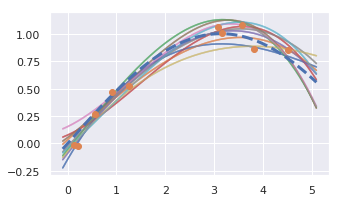

In [10]:
# plot
fig = plt.figure(figsize=(5, 3))
ax = fig.subplots(1,1)
for w in ws:
    sample_prior = list(map(lambda x:np.dot(sample_post_ws, polynomial(x=x, degree=n_degree)), xs))
    ax.plot(xs, sample_prior, '-', alpha=0.3)
ax.plot(xs, tys, '--', lw=3)
ax.plot(sample_x, sample_y, 'o')

### 予測分布の算出
- 予測分布も解析解が得られる

$$
p\left(y_{*} | \mathbf{x}_{*}, \mathbf{Y}, \mathbf{X}\right)=\mathcal{N}\left(y_{*} | \mu_{*}\left(\mathbf{x}_{*}\right), \sigma_{*}^{2}\left(\mathbf{x}_{*}\right)\right)
$$

$$
\begin{array}{l}{\mu_{*}\left(\mathbf{x}_{*}\right)=\hat{\boldsymbol{\mu}}^{\top} \phi\left(\mathbf{x}_{*}\right)} \\ {\sigma_{*}^{2}\left(\mathbf{x}_{*}\right)=\sigma^{2}+\phi\left(\mathbf{x}_{*}\right)^{\top} \hat{\mathbf{\Sigma}} \phi\left(\mathbf{x}_{*}\right)}\end{array}
$$

In [11]:
def mu_pred(x, mu_tr, n_degree=n_degree):
    feature = (np.array(polynomial(x, degree=n_degree)))[:, np.newaxis]
    return (np.dot(mu_tr.T, feature)).flatten()
def var_pred(x, sig_tr):
    feature = (np.array(polynomial(x, degree=n_degree)))[:, np.newaxis]
    fsf = np.dot(feature.T, sig_tr)
    fsf = np.dot(fsf, feature)
    return (np.sqrt(var_y) + fsf).flatten()

mu_s_s = np.array(list(map(lambda x:mu_pred(x, mu_tr=mu_hat), xs))).flatten()
var_s_s = np.array(list(map(lambda x:var_pred(x, sig_tr=S_hat), xs))).flatten()

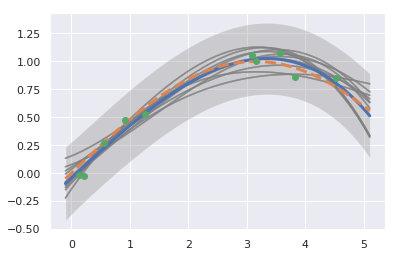

In [12]:
# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

# sampled function(trained W)
for w in ws:
    sample_prior = list(map(lambda x:np.dot(sample_post_ws, polynomial(x=x, degree=n_degree)), xs))
    ax.plot(xs, sample_prior, '-', color='gray', alpha=0.3)

# mean predicted function
ax.plot(xs, mu_s_s, lw=3)

# predicted area
sig_s_s = np.sqrt(var_s_s)
lb = mu_s_s - sig_s_s
ub = mu_s_s + sig_s_s
plt.fill_between(xs, lb, ub, facecolor='gray',alpha=0.3)

# True Function
ax.plot(xs, tys, '--', lw=3)

# Sampled Data
ax.plot(sample_x, sample_y, 'o')

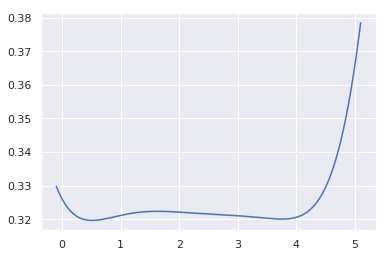

In [13]:
# 予測の分散（不確実性）のプロッt
plt.plot(xs, sig_s_s)